# Using CLIP
We have a good idea of what CLIP can be used for and how it is trained. With that, how can we get started with it?

OpenAI released a few implementations of CLIP via the Hugging Face library; this is the fastest way to get started. First, we need to install the necessary libraries.

In [1]:
pip install transformers torch datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 10.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Before we can do anything with CLIP, we need some text and images. The jamescalam/image-text-demo dataset contains a small number of image-text pairs we can use in our examples.

In [2]:
from datasets import load_dataset

data = load_dataset(
    "jamescalam/image-text-demo",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image-text-demo downloaded and prepared to /root/.cache/huggingface/datasets/jamescalam___image-text-demo/default/0.0.0/407740dbc70c0853dcd126ce90327d5a83d8ac5282831005a054df12d673ab58. Subsequent calls will reuse this data.


With these sample records ready, we can move on to initializing CLIP and an image/text preprocessor like so:

In [3]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

The model is CLIP itself. Note that we use the ViT image encoder (the model is clip-vit). Text and image data cannot be fed directly into CLIP. The text must be preprocessed to create “tokens IDs”, and images must be resized and normalized. The processor handles both of these functions.

# Encoding Text
We will start with encoding text using the CLIP text transformer. Before feeding text into CLIP, it must be preprocessed and converted into token IDs. Let’s take a batch of sentences from the unsplash data and encode them.



In [4]:
text = data['text']  # 21

tokens = processor(
    text=text,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

This returns the typical text transformer inputs of input_ids and attention_mask.

The input_ids are token ID values where each token ID is an integer value ID that maps to a specific word or sub-word. For example the phrase “multi-modality” may be split into tokens [“multi”, “-”, “modal”, “ity”], which are then mapped to IDs [1021, 110, 2427, 425].

A text transformer maps these token IDs to semantic vector embeddings that the model learned during pretraining.

The attention_mask is a tensor of 1s and 0s used by the model’s internal mechanisms to “pay attention” to real token IDs and ignore padding tokens.

*Padding tokens are a special type of token used by text transformers to create input sequences of a fixed length from sentences of varying length. They are appended to the end of shorter sentences, so “hello world” may become “hello world [PAD] [PAD] [PAD]”.*

We then use CLIP to encode all of these text descriptions with get_text_features like so:

In [5]:
text_emb = model.get_text_features(
    **tokens
)

One important thing to note here is that these embeddings are not normalized. If we plan on using a similarity metric like the dot product, we must normalize the embeddings:

In [6]:
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

torch.Size([21, 512])
tensor(-1.1893, grad_fn=<MinBackward1>) tensor(4.8015, grad_fn=<MaxBackward1>)


In [7]:
# IF using dot product similarity, must normalize vectors like so...
import numpy as np

# detach text emb from graph, move to CPU, and convert to numpy array
text_emb = text_emb.detach().cpu().numpy()

# calculate value to normalize each vector by
norm_factor = np.linalg.norm(text_emb, axis=1)
norm_factor.shape

(21,)

In [8]:

text_emb = text_emb.T / norm_factor
# transpose back to (21, 512)
text_emb = text_emb.T
print(text_emb.shape)
print(text_emb.min(), text_emb.max())

(21, 512)
-0.15268452 0.53449893


Alternatively, we can use cosine similarity as our metric as this only considers angular similarity and not vector magnitude (like dot product). For our examples, we will normalize and use dot product similarity.

We now have our text embeddings; let’s see how to do the same for images.

# Encoding Images
Images will be encoded using the ViT portion of CLIP. Similar to text encoding, we need to preprocess these images using the preprocessor like so:

In [9]:
data['image'][0].size

(6000, 3376)

In [10]:
image_batch = data['image']

images = processor(
    text=None,
    images=image_batch,
    return_tensors='pt'
)['pixel_values'].to(device)
images.shape

torch.Size([21, 3, 224, 224])

Preprocessing images does not produce token IDs like those we saw from preprocessing our text. Instead, preprocessing images consists of resizing the image to a 244x244 array with three color channels (red, green, and blue) and normalizing pixel values into a [0,1] range.

After preprocessing our images, we get the image features with get_image_features and normalize them as before:

In [11]:
img_emb = model.get_image_features(images)
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

torch.Size([21, 512])
tensor(-8.6533, grad_fn=<MinBackward1>) tensor(2.6551, grad_fn=<MaxBackward1>)


In [12]:
# NORMALIZE
# detach text emb from graph, move to CPU, and convert to numpy array
img_emb = img_emb.detach().cpu().numpy()

img_emb = img_emb.T / np.linalg.norm(img_emb, axis=1)
# transpose back to (21, 512)
img_emb = img_emb.T
print(img_emb.shape)
print(img_emb.min(), img_emb.max())

(21, 512)
-0.7275359 0.23383307


# Calculating Similarity
CLIP embedding similarities are represented by their angular similarity. Meaning we can identify similar pairs using cosine similarity. Let’s try both. First, for cosine similarity, we do:

In [13]:
from numpy.linalg import norm

cos_sim = np.dot(text_emb, img_emb.T) / (
    norm(text_emb, axis=1) * norm(img_emb, axis=1)
)
cos_sim.shape

(21, 21)

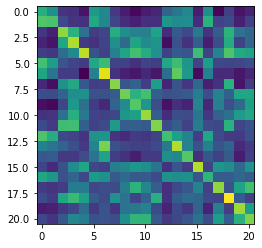

In [14]:
import matplotlib.pyplot as plt

plt.imshow(cos_sim)
plt.show()

And if we perform the same operation for dot product similarity, we should return the same results:

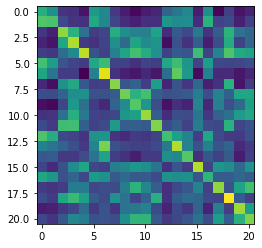

In [15]:
dot_sim = np.dot(text_emb, img_emb.T)

plt.imshow(cos_sim)
plt.show()

Both of these similarity score arrays look the same, and if we check for the difference between the two arrays, we will see that the scores are the same. We see some slight differences due to floating point errors.

In [16]:
diff = cos_sim - dot_sim
diff.min(), diff.max()

(-2.9802322e-08, 2.9802322e-08)

Using the embedding functions of CLIP in this way, we can perform a semantic search across the modalities of text and image in any direction. We can search for images with text, text with images, text with text, and images with images.

These use cases are great, but we can make slight modifications to this for many other tasks.

#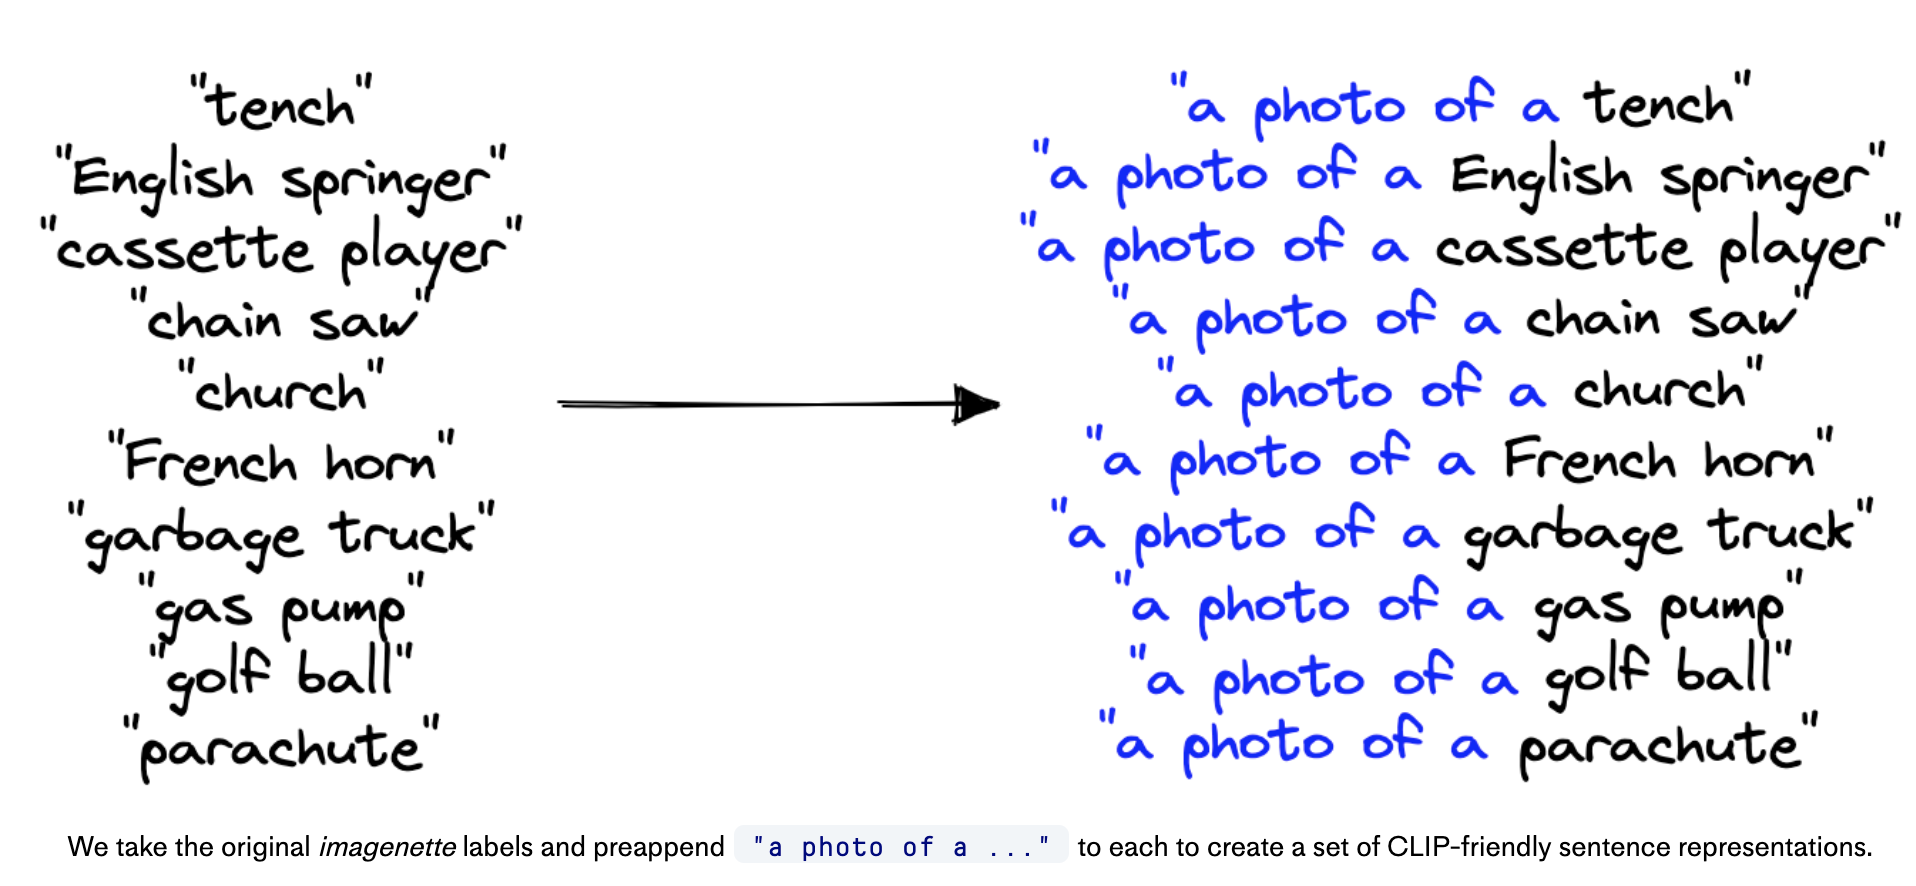Classification
One of the most impressive demonstrations of CLIP is its unparalleled zero-shot performance on various tasks. For example, given the fragment/imagenette dataset from Hugging Face Datasets, we can write a list of brief sentences that align with the ten class labels.


